(<Figure size 1500x1000 with 1 Axes>,
 Text(0.5, 1.0, 'hucre'))

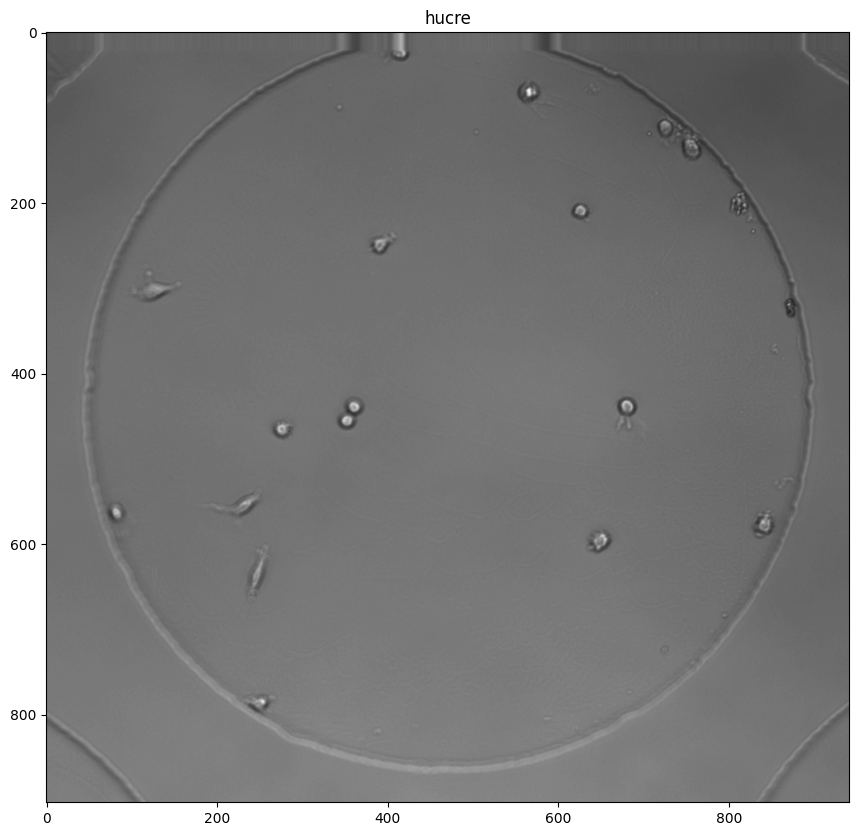

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.measure import label, regionprops, regionprops_table

img = cv2.imread('hucre.png', 0)
plt.figure(figsize = (15,10)),plt.imshow(img,cmap='gray'),plt.title('hucre')

(<Figure size 1500x1000 with 1 Axes>,
 Text(0.5, 1.0, 'sharpened_img'))

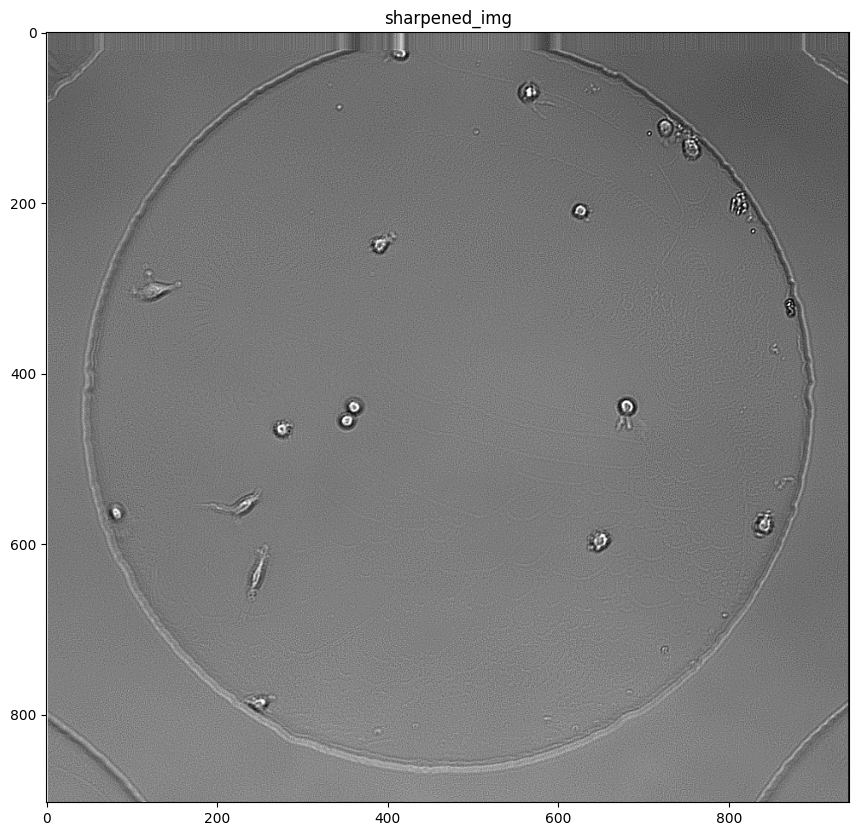

In [2]:
# 1. Verilen görüntüye öncelikli olarak keskinleştirme işlemi uygulayın
sharpening_kernel = np.array([[-1, -1, -1],
                              [-1, 9, -1],
                              [-1, -1, -1]])
sharpened_img = cv2.filter2D(src=img, ddepth=-1, kernel=sharpening_kernel)
plt.figure(figsize = (15,10)),plt.imshow(sharpened_img,cmap='gray'),plt.title('sharpened_img')

(<Figure size 1500x1000 with 1 Axes>,
 Text(0.5, 1.0, 'sobel_thresholded_img'))

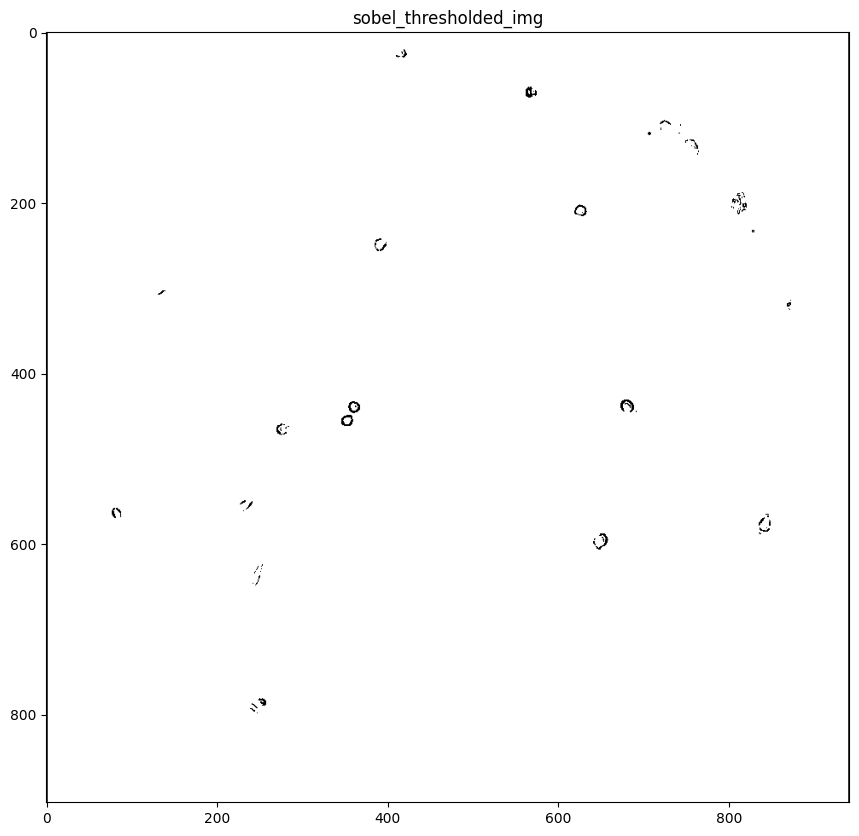

In [3]:
# 2. Elde edilen görüntüye en uygun eşikleme yöntemini uygulayarak ikili görüntüye dönüştürün.
# improved thresholding
x = cv2.Sobel(img, cv2.CV_16S, 1, 0, ksize=3)
y = cv2.Sobel(img, cv2.CV_16S, 0, 1, ksize=3)
absX = cv2.convertScaleAbs(x)
absY = cv2.convertScaleAbs(y)
sobel = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)
_, sobel_thresholded_img = cv2.threshold(sobel, 100, 255, cv2.THRESH_BINARY_INV)
plt.figure(figsize = (15,10)),plt.imshow(sobel_thresholded_img,cmap='gray'),plt.title('sobel_thresholded_img')

(<Figure size 1500x1000 with 1 Axes>,
 Text(0.5, 1.0, 'edges_img'))

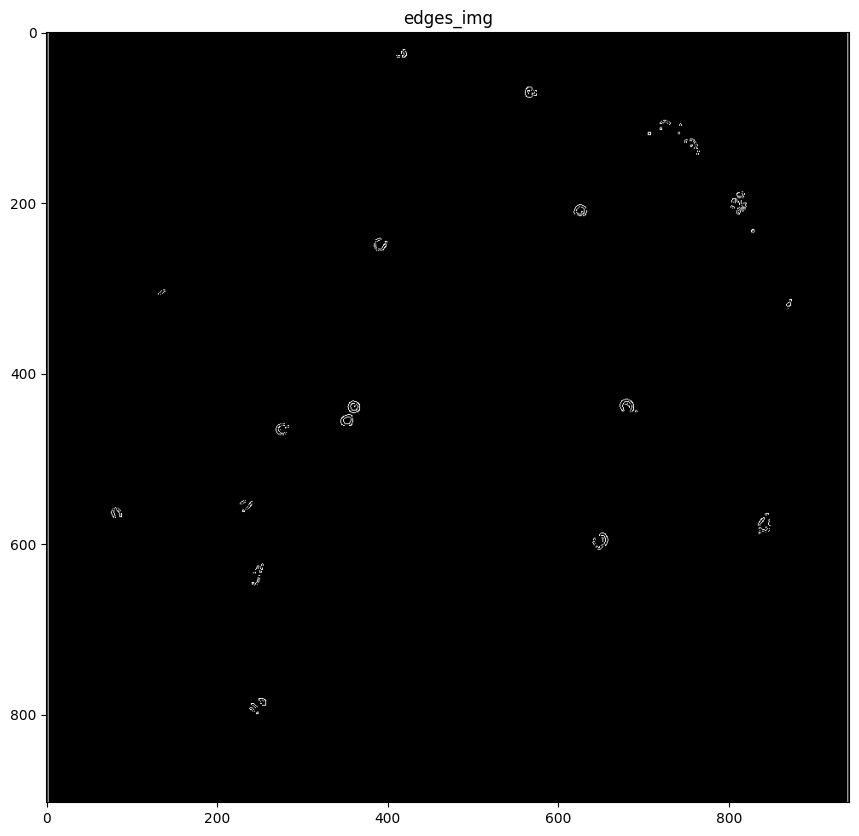

In [4]:
edges_img = cv2.Canny(sobel_thresholded_img,200,255)
plt.figure(figsize = (15,10)),plt.imshow(edges_img,cmap='gray'),plt.title('edges_img')

(<Figure size 1500x1000 with 1 Axes>,
 Text(0.5, 1.0, 'eroded_img_elliptic_5_5'))

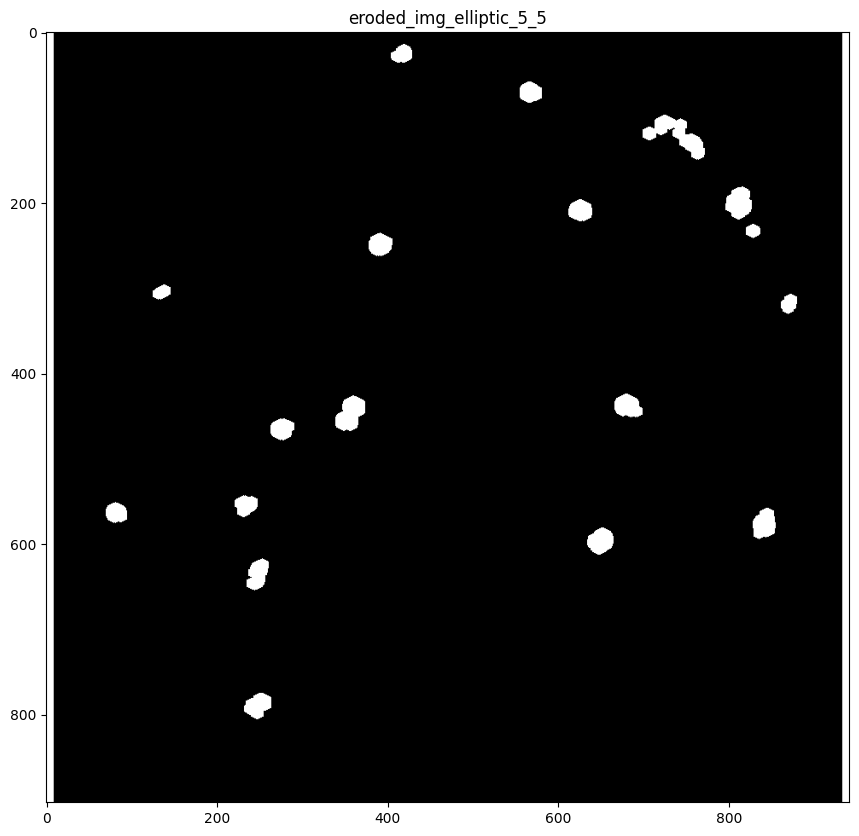

In [23]:
# 3. Çıktı çok sayıda bileşen içeriyorsa, bileşen sayısını azaltmak için morfolojik bir teknik uygulayın, (örneğin bileşen boyutuna göre filtreleme veya erozyon)
I_img=edges_img.astype(np.uint8)

#kernel = np.ones((3,3),np.uint8)
#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
kernel =cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))

eroded_img = cv2.dilate(I_img,kernel,iterations=3)
plt.figure(figsize = (15,10)),plt.imshow(eroded_img,cmap='gray'),plt.title('eroded_img_elliptic_5_5')

(<Figure size 1500x1000 with 1 Axes>,
 Text(0.5, 1.0, 'components_img'))

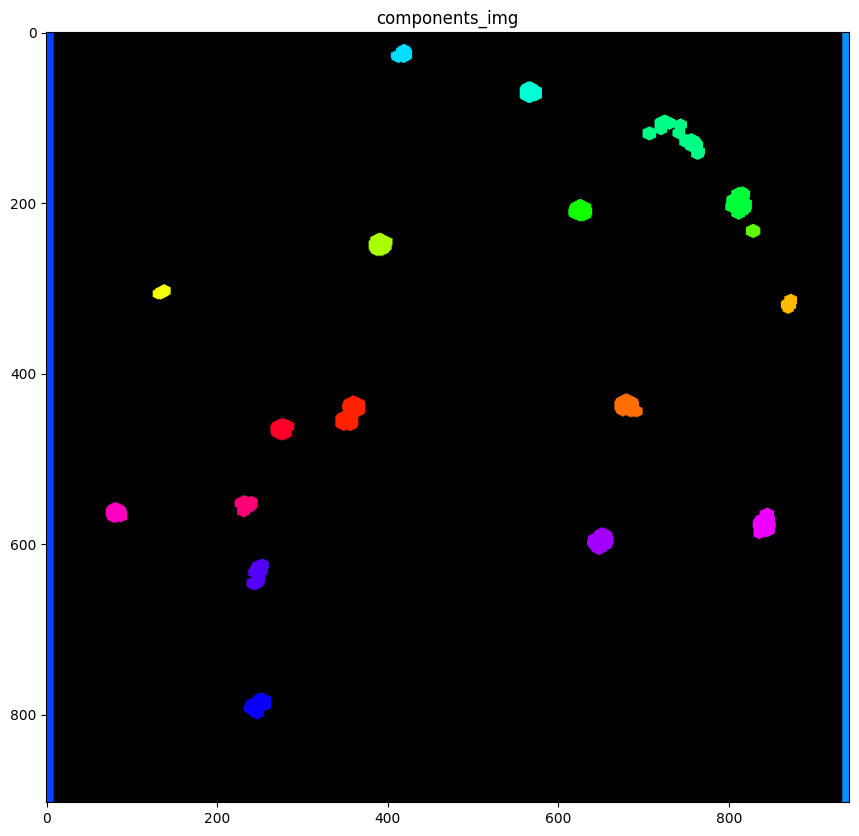

In [6]:
# 4. Verilen görüntülere Bağlantı bileşen etiketleme (connected component labeling) algoritması uygulayın
nb_components, comp, stats, centroids = cv2.connectedComponentsWithStats(eroded_img, connectivity=8)
sizes = stats[1:, -1]; nb_components = nb_components - 1
min_size=np.max(sizes)
# 5. Algılanan bileşenleri/nesneleri farklı renklerle görüntüleyerek sonuçlarınızı gösterin
#cv2 gösterimi için component değerlerini renklendirme (kaynak: https://stackoverflow.com/questions/46441893/connected-component-labeling-in-python)
label_hue = np.uint8(179 * comp / np.max(comp))
blank_ch = 255 * np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
labeled_img[label_hue == 0] = 0
plt.figure(figsize = (15,10)),plt.imshow(labeled_img,cmap='gray'),plt.title('components_img')

In [7]:
# 6. İlgili her bölge/nesne için alanı, yönü ve daireselliği (Area,orientation, circularity) hesaplayın.

components = regionprops(comp)
print("-----------------------------------------------------------------------------------------------------------------")
print("-------İlgili her bölge/nesne için alanı, yönü ve daireselliği (Area,orientation, circularity) hesaplaması.------")
for i in range(0, nb_components):
    area = components[i].area
    orientation = components[i].orientation
    #circularity calculation (kaynak: https://stackoverflow.com/questions/74580811/circularity-calculation-with-perimeter-area-of-a-simple-circle)
    circularity = (4*np.pi*area) / (components[i].perimeter ** 2)
    print("Component -",i,": area:",area,", orientation: ",orientation,", circularity:",circularity)

print("-----------------------------------------------------------------------------------------------------------------")


-----------------------------------------------------------------------------------------------------------------
-------İlgili her bölge/nesne için alanı, yönü ve daireselliği (Area,orientation, circularity) hesaplaması.------
Component - 0 : area: 8127.0 , orientation:  0.0 , circularity: 0.030831691215703717
Component - 1 : area: 8127.0 , orientation:  0.0 , circularity: 0.030831691215703717
Component - 2 : area: 410.0 , orientation:  -1.164247291018316 , circularity: 0.8355196772233848
Component - 3 : area: 515.0 , orientation:  1.4161109908667306 , circularity: 0.9057890936102615
Component - 4 : area: 1514.0 , orientation:  1.1077263191908675 , circularity: 0.28025234501104396
Component - 5 : area: 886.0 , orientation:  -0.1587789150305613 , circularity: 0.790621595013193
Component - 6 : area: 565.0 , orientation:  1.496819587072075 , circularity: 0.8844267655386782
Component - 7 : area: 215.0 , orientation:  -1.5668289886901348 , circularity: 0.9251058675629368
Component - 8 : ar

------------------------------------------------------------------------------------------------------------------
-----------------------Her bölgenin alanın çevreye oranı (compactness) hesaplaması:-------------------------------
Component - 0 : area/perimeter (compactness): 6.613636363636363
Component - 1 : area/perimeter (compactness): 3.964835164835165
Component - 2 : area/perimeter (compactness): 3.964835164835165
Component - 3 : area/perimeter (compactness): 4.801282051282051
Component - 4 : area/perimeter (compactness): 5.6726190476190474
Component - 5 : area/perimeter (compactness): 5.382692307692308
Component - 6 : area/perimeter (compactness): 7.055084745762712
Component - 7 : area/perimeter (compactness): 5.898876404494382
Component - 8 : area/perimeter (compactness): 3.5277777777777777
Component - 9 : area/perimeter (compactness): 5.840425531914893
Component - 10 : area/perimeter (compactness): 3.8333333333333335
Component - 11 : area/perimeter (compactness): 4.3
Component -

(<Figure size 1500x1000 with 1 Axes>,
 Text(0.5, 1.0, 'label_edged_image'))

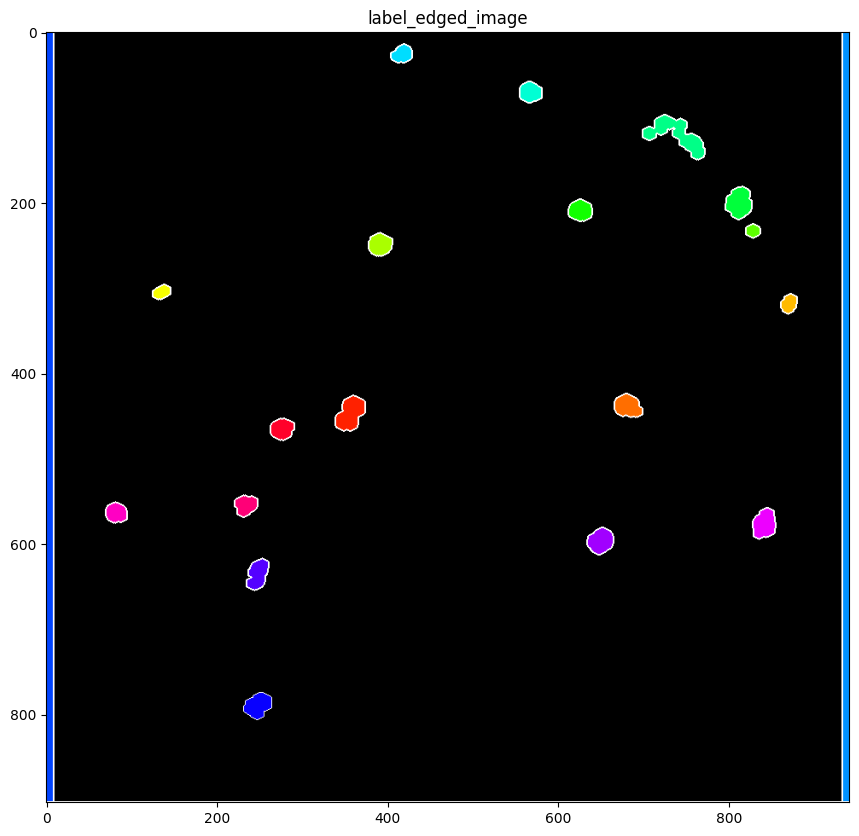

In [8]:
# 7. Her bölgenin sınır piksellerini tanımlayın (edge detection) ve alanın çevreye oranını, kompaktlığı (compactness, the ratio of the area to the perimeter) hesaplayın

cx=np.zeros(26)
cy=np.zeros(26)
area=np.zeros(26)
perimeter=np.zeros(26, dtype=int)
aspect_ratio=np.zeros(26)
equi_diameter=np.zeros(26)
print("------------------------------------------------------------------------------------------------------------------")
print("-----------------------Her bölgenin alanın çevreye oranı (compactness) hesaplaması:-------------------------------")
label_edged_img = labeled_img
for i in range(0, nb_components):
    component_img = np.zeros((comp.shape), dtype = np.uint8)
    component_img[comp == i] = 255
    # moments
    contours,hierarchy = cv2.findContours(component_img, 1, 2)
    label_edged_img = cv2.drawContours(label_edged_img, contours, -1, (255, 255, 255), 1)

    cnt = contours[0]
    M = cv2.moments(cnt)
    # center
    cx[i] = round(M['m10']/M['m00'])
    cy[i] = round(M['m01']/M['m00'])
    # contour area
    area[i] = cv2.contourArea(cnt)
    # perimeter
    perimeter[i] = cv2.arcLength(cnt,True)
    # aspect ratio
    x,y,w,h = cv2.boundingRect(cnt)
    aspect_ratio[i] = float(w)/h
    # eq dia
    are = cv2.contourArea(cnt)
    equi_diameter[i] = np.sqrt(4*are/np.pi)
    print("Component -",i, ": area/perimeter (compactness):", area[i]/perimeter[i])

print("-----------------------------------------------------------------------------------------------------------------")
plt.figure(figsize = (15,10)),plt.imshow(label_edged_img,cmap='gray'),plt.title('label_edged_image')